# Quickstart

## Estimating activities of fixed signatures

To inject fixed signature definitions into the probabilistic model, we use pymc3's "observed variable" functionality. Once observed, the signature definitions will not be updated during inference. 


In [23]:
import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
import damuta as da
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
# Load data for 100 patients
counts = pd.read_csv('example_data/pcawg_counts.csv', index_col=0).head(100)
annotation = pd.read_csv('example_data/pcawg_cancer_types.csv', index_col=0).head(100)
pcawg = da.DataSet(counts, annotation)

To fix the damage signatures, we will observe phi. To fix the misrepair signatures, we will observe eta in the C context, and in the T context. 

In [25]:
damuta_sigs = da.SignatureSet.from_damage_misrepair(
    pd.read_csv('example_data/damage_signatures.csv', index_col=0), 
    pd.read_csv('example_data/misrepair_signatures.csv', index_col=0))

In [5]:
ht_lda = da.models.HierarchicalTandemLda(pcawg, type_col = 'pcawg_class',
                                         phi_obs= damuta_sigs.damage_signatures.to_numpy(), 
                                         etaC_obs= damuta_sigs.misrepair_signatures[['C>A', 'C>G', 'C>T']].to_numpy(),
                                         etaT_obs= damuta_sigs.misrepair_signatures[['T>A', 'T>C', 'T>G']].to_numpy())

ht_lda._build_model(**ht_lda._model_kwargs)

In [6]:
ht_lda.fit(n=10000)

Finished [100%]: Average Loss = 4.641e+05


Check for nice convergence

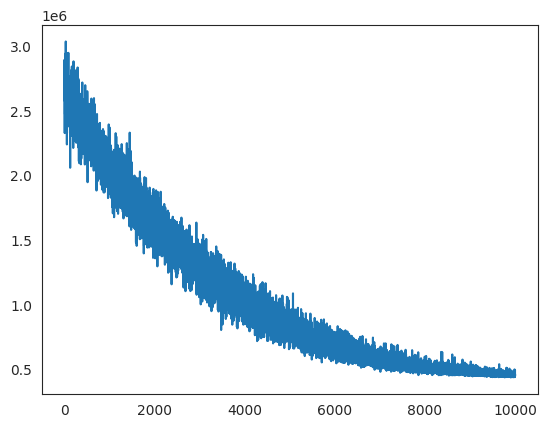

In [10]:
plt.plot(ht_lda.approx.hist)

## Under the hood

Signature activities can be estimated from the product of the damage activities ($\theta$) and the association matrix ($A$). We call this product $W$, where for draw $d$ from the posterior, genome $g$, damage signature $i$ and misrepair signature $j$, $W_{dgij} = \theta_{dgi} A_{dgij}$. Because of the compositional properties of signature activities, $\Sigma_{i}\theta_{dgi} = 1$ and $\Sigma_{j}A_{dgij} = 1$. This means we can conveinently marginalize over the damage, and misrepair axes of $W$ to get damage activities $\theta_{dgi} = \Sigma_{j}W_{dgij}$ and misrepair activities $\Gamma_{gdj} = \Sigma_{i}W_{dgij}$



Let's see this in code:

In [11]:
trace = ht_lda.approx.sample(10)
trace

<MultiTrace: 1 chains, 10 iterations, 17 variables>

In [12]:
print("theta shape: ", trace.theta.shape)
print("A shape: ", trace.A.shape)

# reshape A for broadcasting 
# nb. only necssary for hierarchical model
A = np.moveaxis(trace.A,1,2)
print("A reshaped: ", A.shape)

# compute W
W = (trace.theta[:,:,:,None]*A)
print("W shape: ", W.shape)

# check that W sums to theta over the misrepair axis
print("W correctly marginalizes to theta: ", np.allclose(W.sum(-1), trace.theta))

theta = W.sum(-1)
gamma = W.sum(-2)

# display mean over 10 posterior samples
display(pd.DataFrame(theta.mean(0)))
display(pd.DataFrame(gamma.mean(0)))

theta shape:  (10, 100, 18)
A shape:  (10, 18, 100, 6)
A reshaped:  (10, 100, 18, 6)
W shape:  (10, 100, 18, 6)
W correctly marginalizes to theta:  True


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.018148,0.041422,0.014217,0.052663,0.049612,0.058811,0.071537,0.130497,0.066573,0.035261,0.021667,0.124121,0.016808,0.030907,0.047377,0.071972,0.010440,0.137968
1,0.196696,0.004420,0.018841,0.013270,0.016926,0.023671,0.162195,0.036593,0.076675,0.004726,0.011317,0.014630,0.046820,0.001704,0.091335,0.083935,0.110214,0.086030
2,0.027179,0.006244,0.020942,0.027659,0.007212,0.034248,0.241564,0.087762,0.029229,0.004069,0.006210,0.070710,0.011210,0.035043,0.059892,0.302042,0.011307,0.017476
3,0.162715,0.004495,0.024484,0.009229,0.004569,0.041733,0.107043,0.059714,0.041113,0.005306,0.005099,0.077870,0.032388,0.010351,0.045068,0.151163,0.194221,0.023440
4,0.048726,0.018671,0.032167,0.007728,0.022793,0.087195,0.101831,0.098192,0.027594,0.013096,0.010840,0.159202,0.026011,0.014519,0.140401,0.085658,0.087918,0.017457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.023237,0.019154,0.055715,0.034148,0.021770,0.023628,0.105320,0.071424,0.036490,0.016433,0.017406,0.146123,0.033986,0.041399,0.088043,0.140026,0.047384,0.078316
96,0.093214,0.020699,0.045064,0.006078,0.028922,0.009975,0.060595,0.115997,0.037020,0.019665,0.025236,0.122353,0.013375,0.007978,0.087475,0.055401,0.183467,0.067485
97,0.076210,0.067483,0.022933,0.066986,0.074895,0.005201,0.042560,0.062713,0.028507,0.047743,0.024556,0.085347,0.026325,0.074539,0.064278,0.060788,0.119847,0.049088
98,0.003044,0.548510,0.011509,0.002059,0.162906,0.002314,0.001786,0.002327,0.002376,0.233313,0.011635,0.002660,0.001525,0.001529,0.004957,0.002173,0.003206,0.002169


,0,1,2,3,4,5
0,0.119163,0.076473,0.033622,0.310843,0.269885,0.190014
1,0.140634,0.207480,0.173554,0.163602,0.179140,0.135590
2,0.054899,0.075041,0.357446,0.180587,0.311875,0.020151
3,0.145366,0.079770,0.395346,0.118004,0.064376,0.197138
4,0.169410,0.085609,0.276751,0.183347,0.103106,0.181778
...,...,...,...,...,...,...
95,0.096294,0.147463,0.156497,0.402184,0.147838,0.049724
96,0.195606,0.115633,0.135081,0.174319,0.179204,0.200157
97,0.144579,0.157569,0.080419,0.222177,0.083163,0.312092
98,0.039981,0.020032,0.152037,0.574859,0.018432,0.194659


This functionality is implemented in the `TandemLDA` class as the convience method `get_estimated_activities_DataFrame()` which also adds back the sample index and turns it into a data frame. You could equally run this several times to get multiple posterior samples. 

To get the estimated activities for the signatures we provided:

In [13]:
theta_df, gamma_df = ht_lda.get_estimated_activities_DataFrame()
display(theta_df)
display(gamma_df)


,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18
0009b464-b376-4fbc-8a56-da538269a02f,0.023905,0.042144,0.012821,0.067622,0.056636,0.052268,0.082317,0.125302,0.062317,0.015641,0.014897,0.094237,0.012628,0.026428,0.068918,0.082709,0.005059,0.154153
003819bc-c415-4e76-887c-931d60ed39e7,0.342639,0.000648,0.000514,0.006578,0.001124,0.028850,0.302648,0.020001,0.009185,0.001387,0.004508,0.002299,0.018233,0.000272,0.052665,0.128304,0.069978,0.010169
0040b1b6-b07a-4b6e-90ef-133523eaf412,0.023239,0.011639,0.034848,0.020823,0.007424,0.042319,0.187420,0.131227,0.031996,0.009143,0.002698,0.094749,0.015183,0.038535,0.138407,0.188625,0.009798,0.011924
00493087-9d9d-40ca-86d5-936f1b951c93,0.101447,0.008213,0.013212,0.010309,0.005631,0.054491,0.121498,0.051175,0.032020,0.009884,0.003356,0.122218,0.036383,0.009040,0.046290,0.121395,0.216920,0.036517
00508f2b-36bf-44fc-b66b-97e1f3e40bfa,0.076686,0.015870,0.031908,0.005782,0.053613,0.040126,0.136935,0.066822,0.037307,0.015242,0.006176,0.096585,0.024535,0.010237,0.201561,0.077706,0.076108,0.026801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
09508a0d-ebe0-4fa1-b7b2-1710814181cd,0.014024,0.011455,0.042805,0.025631,0.024104,0.018295,0.159575,0.060968,0.041322,0.016498,0.014966,0.119394,0.034835,0.045682,0.144392,0.098213,0.044423,0.083417
09537dce-c797-4b60-962a-d4c3cd6ab00a,0.058662,0.027545,0.069911,0.006142,0.014077,0.013516,0.040982,0.075351,0.033984,0.012531,0.020908,0.086793,0.035255,0.010054,0.047830,0.056556,0.313982,0.075921
0972bfcf-c6c6-48cc-b820-cdfa6279a4f3,0.102685,0.088997,0.027429,0.055779,0.096025,0.006440,0.027940,0.047849,0.024664,0.042652,0.018933,0.084635,0.031575,0.085959,0.042514,0.057240,0.102292,0.056391
097a7d36-905b-72be-e050-11ac0d482c9a,0.002253,0.502181,0.007545,0.003651,0.146801,0.002077,0.002475,0.002219,0.003480,0.302682,0.007014,0.001481,0.001848,0.001913,0.004758,0.001927,0.002163,0.003533


,M1,M2,M3,M4,M5,M6
0009b464-b376-4fbc-8a56-da538269a02f,0.216004,0.073933,0.029688,0.213874,0.283196,0.183304
003819bc-c415-4e76-887c-931d60ed39e7,0.106277,0.192278,0.297297,0.079554,0.190696,0.133898
0040b1b6-b07a-4b6e-90ef-133523eaf412,0.057356,0.082956,0.455159,0.125351,0.258156,0.021023
00493087-9d9d-40ca-86d5-936f1b951c93,0.116519,0.084419,0.374920,0.138902,0.057322,0.227917
00508f2b-36bf-44fc-b66b-97e1f3e40bfa,0.184631,0.112263,0.333812,0.143893,0.069998,0.155402
...,...,...,...,...,...,...
09508a0d-ebe0-4fa1-b7b2-1710814181cd,0.102007,0.172737,0.135884,0.403288,0.128281,0.057803
09537dce-c797-4b60-962a-d4c3cd6ab00a,0.221085,0.090471,0.089220,0.152718,0.224753,0.221753
0972bfcf-c6c6-48cc-b820-cdfa6279a4f3,0.140435,0.180135,0.082728,0.243320,0.092420,0.260961
097a7d36-905b-72be-e050-11ac0d482c9a,0.034730,0.015996,0.110241,0.587700,0.017674,0.233658


The DAMUTA model classes wrap pymc3 - we just saw how to sample a `MultiTrace` from the posterior, and we can also turn this into arviz `InferenceData`

In [14]:
idata = az.from_pymc3(trace, model = ht_lda.model)

In [15]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> observed_data
	> constant_data

## Visualizing uncertainty

We've stepped through several ways to get posterior samples. For most purposes, the `get_estimated_activities_DataFrame()` method is probably suitable to work with. However, it returns the mean of samples from the posterior, so when we want to make use of uncertainty estimates we should use the array equivalent: `get_estimated_activities()` which can return objects with >2 dimensions. 

These objects are calculated as described above in "Under the hood" and dimensions correspond to `n_draws x n_genomes x n_signatures` 



In [16]:
theta, gamma = ht_lda.get_estimated_activities(n_draws = 10)

print("theta shape: ", theta.shape)
print("gamma shape: ", gamma.shape)

theta shape:  (10, 100, 18)
gamma shape:  (10, 100, 6)


Let's look at just the first three patients. We can view the damage signature activity and the uncertainty, taking the mean and standard deviation of our 10 samples. 

In [17]:
patient_index = [0,1,2]
display(pcawg.annotation.iloc[patient_index])

,pcawg_class
guid,
0009b464-b376-4fbc-8a56-da538269a02f,Ovary-AdenoCA
003819bc-c415-4e76-887c-931d60ed39e7,CNS-PiloAstro
0040b1b6-b07a-4b6e-90ef-133523eaf412,Liver-HCC


lets compile our theta and gamma samples into dataframes, for easy visualization

In [18]:
theta_df = pd.concat([pd.DataFrame(theta[draw,patient_index,:], 
              index = pcawg.annotation.iloc[patient_index].index, 
              columns = ["D"+str(i+1) for i in range(ht_lda.n_damage_sigs)]).assign(posterior_sample = draw) for draw in range(10)])

theta_df['pcawg_class'] = pcawg.annotation.iloc[patient_index].pcawg_class
theta_df = theta_df.melt(id_vars = ['pcawg_class', 'posterior_sample'], var_name = 'Damage signature', value_name = 'theta')
theta_df.head()

,pcawg_class,posterior_sample,Damage signature,theta
0,Ovary-AdenoCA,0,D1,0.022982
1,CNS-PiloAstro,0,D1,0.030673
2,Liver-HCC,0,D1,0.024449
3,Ovary-AdenoCA,1,D1,0.015198
4,CNS-PiloAstro,1,D1,0.047383


In [19]:
gamma_df = pd.concat([pd.DataFrame(gamma[draw,patient_index,:], 
              index =  pcawg.annotation.iloc[patient_index].index, 
              columns = ["M"+str(i+1) for i in range(ht_lda.n_misrepair_sigs)]).assign(posterior_sample = draw) for draw in range(10)])
gamma_df['pcawg_class'] = pcawg.annotation.iloc[patient_index].pcawg_class
gamma_df = gamma_df.melt(id_vars = ['pcawg_class', 'posterior_sample'], var_name = 'Misrepair signature', value_name = 'gamma')
gamma_df.head()

,pcawg_class,posterior_sample,Misrepair signature,gamma
0,Ovary-AdenoCA,0,M1,0.095974
1,CNS-PiloAstro,0,M1,0.133630
2,Liver-HCC,0,M1,0.037630
3,Ovary-AdenoCA,1,M1,0.108157
4,CNS-PiloAstro,1,M1,0.144083


Now plot the activities and uncertainty!

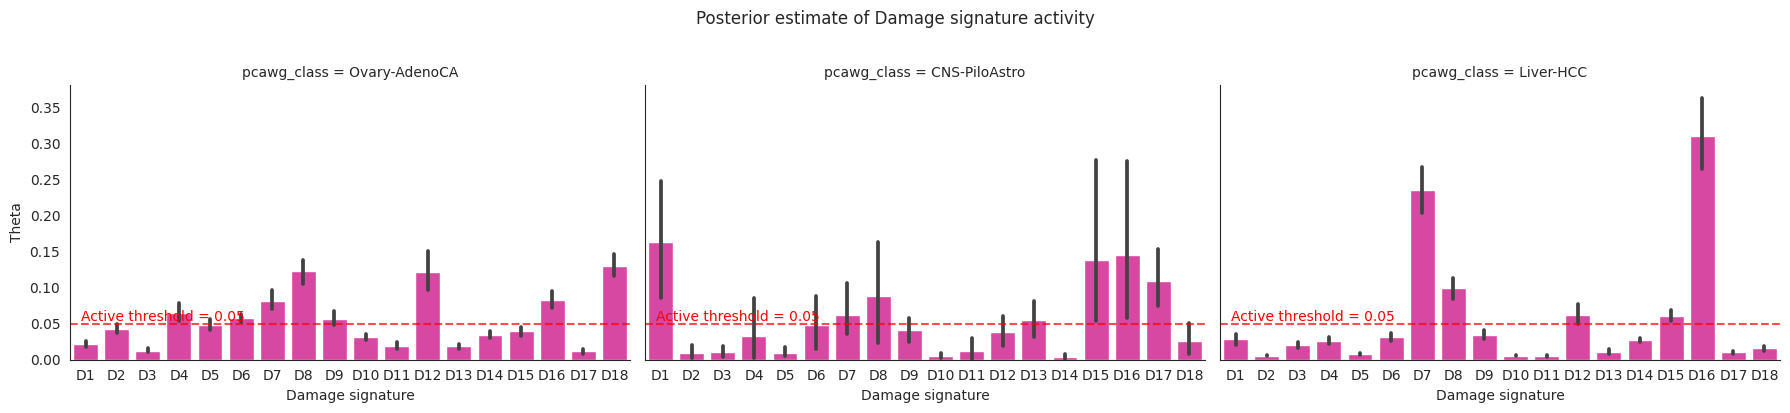

In [20]:
g = sns.FacetGrid(theta_df, col='pcawg_class', col_wrap=3, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x='Damage signature', y='theta', color = '#EE30A7')
g.fig.suptitle('Posterior estimate of Damage signature activity', y=1.02)
g.set_axis_labels('Damage signature', 'Theta')
for ax in g.axes.flat:
    ax.text(2.5, 0.05, 'Active threshold = 0.05', ha='center', va='bottom', fontsize=10, color='red')
    ax.axhline(y=0.05, color='red', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

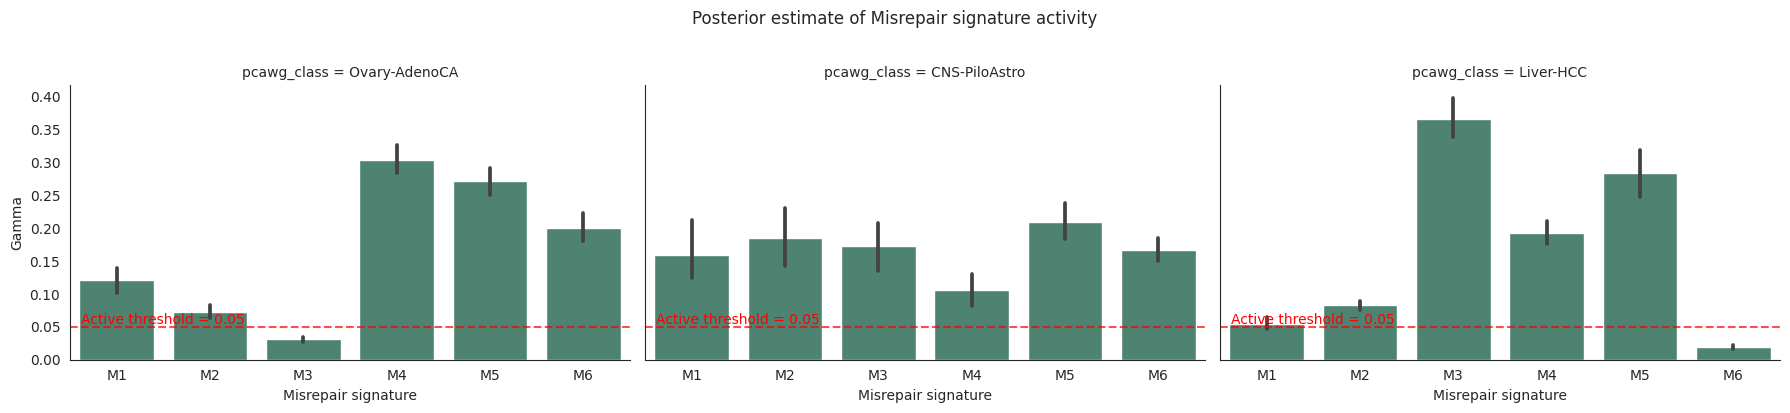

In [21]:
g = sns.FacetGrid(gamma_df, col='pcawg_class', col_wrap=3, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x='Misrepair signature', y='gamma', color = '#458B74')
g.fig.suptitle('Posterior estimate of Misrepair signature activity', y=1.02)
g.set_axis_labels('Misrepair signature', 'Gamma')
for ax in g.axes.flat:
    ax.text(0.5, 0.05, 'Active threshold = 0.05', ha='center', va='bottom', fontsize=10, color='red')
    ax.axhline(y=0.05, color='red', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()